The US National Oceanic and Atmospheric Administration (NOAA) publishes climate data through the National Centers for Environmental Information (NCEI), with daily measurements called the [Global \[Surface\] Summary of Day (GSOD)](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00516). Per this page, "The data are reported and summarized based on Greenwich Mean Time (GMT, 0000Z - 2359Z) since the original synoptic/hourly data are reported and based on GMT." 

The data is available in many forms, including raw CSV [here](https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/). This is organized by year, and then by a file per data-collecting station. The stations are identified by a combination of USAF (Air Force station ID) and WBAN (NCDC (National Climatic Data Center) Weather Bureau Army Navy number) identifiers. These stations are further located by latitude and longitude in this stations list file: [https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv](https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv) (and in [txt](https://www.ncei.noaa.gov/pub/data/noaa/isd-history.txt) format)

I want to do analysis on climate data for Chicago year over year, so I want to find a station in the Chicago area with the greatest year-over-year coverage of data (maximum days per year of data). 

More details about the formats of these GSOD data files can be found in the [README](https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt).

Taking the latitude/longitude of the approximate center of Chicago per [OpenStreetMap](https://wiki.openstreetmap.org/wiki/Chicago,_Illinois#:~:text=Chicago%20is%20a%20city%20in,%C2%B039%E2%80%B254.00%E2%80%B3%20West.) as `(41.868, -87.665)`, we can find the closest station using the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) for great circle distances. 

         USAF   WBAN                          STATION NAME CTRY STATE  ICAO  \
28239  998499  99999                      NORTHERLY ISLAND   US    IL   NaN   
20060  725340  14819              CHICAGO MIDWAY INTL ARPT   US    IL  KMDW   
27689  997255  99999                 9087044 - CALUMET  IL   US   NaN   NaN   
27765  997338  99999                               CHICAGO   US    IL   NaN   
20027  725300  94846  CHICAGO O'HARE INTERNATIONAL AIRPORT   US    IL  KORD   
21634  744665   4838              PALWAUKEE MUNICIPAL ARPT   US    IL  KPWK   
20057  725337   4807                  GARY/CHICAGO AIRPORT   US    IN  KGYY   
18063  722126   4879                  LANSING MUNICIPAL AP   US    IL  KIGQ   
20070  725348   4831              LEWIS UNIVERSITY AIRPORT   US    IL  KLOT   
20028  725305  94892                        DUPAGE AIRPORT   US    IL  KDPA   

          LAT     LON  ELEV(M)     BEGIN       END  distance_to_chicago  \
28239  41.856 -87.609    190.0  20120618  20231125     

<Axes: xlabel='LON', ylabel='LAT'>

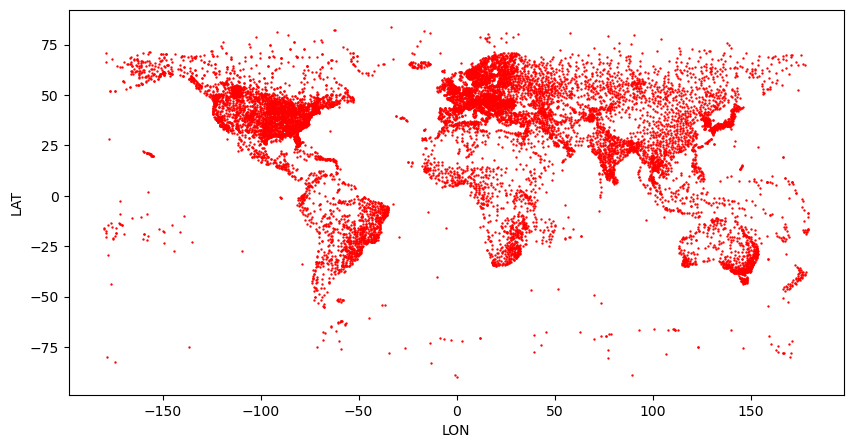

In [11]:
import pandas as pd
from haversine import haversine
import requests
import datetime
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 5]

def distanceToChicago(station):
    chicagoLatLong = (41.868, -87.665)
    return haversine((station['LAT'], station['LON']), chicagoLatLong)

def daysExpected(station):
    begin = datetime.datetime.strptime(station['BEGIN'], '%Y%m%d')
    end = datetime.datetime.strptime(station['END'], '%Y%m%d')
    return (end - begin).days

stations = pd.read_csv('https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv', dtype={'BEGIN': 'string', 'END': 'string'})
stations.dropna(subset=['LAT', 'LON'], inplace=True)
stations['distance_to_chicago'] = stations.apply(distanceToChicago, axis=1)
stations['days_expected'] = stations.apply(daysExpected, axis=1)
stations['begin_year'] = stations['BEGIN'].str.slice(0, 4)
stations['end_year'] = stations['END'].str.slice(0, 4)
stations.sort_values('distance_to_chicago', inplace=True)
# I'm really only interested in stations with current data
stations = stations[stations['end_year'].str.contains('2023')]
print(stations.head(10))

stations.plot(x='LON', y='LAT', kind='scatter', s=0.5, c='red')

Visually inspecting this, I see the two stations with the highest date coverage and the closest distance to Chicago are "CHICAGO MIDWAY INTL ARPT" and "CHICAGO O'HARE INTERNATIONAL AIRPORT".

Later we'll need to confirm quality and coverage of data with the actual data files.

In [12]:
chicagoStations = stations[stations['STATION NAME'].isin(['CHICAGO MIDWAY INTL ARPT', 'CHICAGO O\'HARE INTERNATIONAL AIRPORT'])]
print(chicagoStations)

         USAF   WBAN                          STATION NAME CTRY STATE  ICAO  \
20060  725340  14819              CHICAGO MIDWAY INTL ARPT   US    IL  KMDW   
20027  725300  94846  CHICAGO O'HARE INTERNATIONAL AIRPORT   US    IL  KORD   

          LAT     LON  ELEV(M)     BEGIN       END  distance_to_chicago  \
20060  41.784 -87.755    185.8  19730101  20231126             11.95220   
20027  41.960 -87.932    204.8  19461001  20231127             24.34657   

       days_expected begin_year end_year  
20060          18591       1973     2023  
20027          28181       1946     2023  


In [15]:
def checkUrlExists(url):
    try:
        # By only sending an HTTP HEAD request, we don't consume bandwidth 
        # by actually requesting the whole resource. We just check that it responds.
        response = requests.head(url)
        return response.status_code  == requests.codes.ok
    except requests.ConnectionError:
        print(f"Failed to connect to {url}.")
        return False

def gsodUrl(station, year):
    usaf, wban = station['USAF'], station['WBAN']
    return f"https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/{year}/{usaf}{wban}.csv"

def checkAllDataExists(station):
    allExists = True
    beginYear, endYear = map(int, [station['begin_year'], station['end_year']])
    for year in range(beginYear, endYear + 1):
        requestUrl = gsodUrl(station, year)
        if checkUrlExists(requestUrl):
            # print(f"Data exists for year {year} at {requestUrl}")
            pass
        else:
            print(f"WARNING: Missing data for year {year} at {requestUrl}")
            allExists = False
    if allExists:
        print(f"All data files for years {beginYear} to {endYear} exist!")
    return allExists

# Let's check each of the Chicago stations to make sure we have all the data we expect:
for station in chicagoStations.iloc:
    name = station['STATION NAME']
    print(f"Checking that data exists for {name}")
    checkAllDataExists(station)

Checking that data exists for CHICAGO MIDWAY INTL ARPT
All data files for years 1973 to 2023 exist!
Checking that data exists for CHICAGO O'HARE INTERNATIONAL AIRPORT


Oh no! There are missing data files for years 1970, 1971, and 1972 for the "CHICAGO O'HARE INTERNATIONAL AIRPORT" station. This won't do. Interestingly, this data is available when going through [this page](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094846/detail), but the files apparently aren't present in this GSOD CSV format. 

I'll just use the "CHICAGO MIDWAY INTL ARPT" station then and satisfy myself with data from 1973 to present day. Based on the BEGIN/END dates in the original station index file, I'm expecting to see 18587 days of data whereas the actual data we get back from GSOD has 18546 days worth of measurements, leaving a discreprancy of 41 days. The cause of this discrepancy may be in how the Python `timedelta` object calculates difference of two dates ([https://docs.python.org/3/library/datetime.html#timedelta-objects](https://docs.python.org/3/library/datetime.html#timedelta-objects)).  

In [42]:
def getAllData(station):
    beginYear, endYear = station['begin_year'], station['end_year']
    name = station['STATION NAME']
    data = []
    print(f"Downloading data for {name} from {beginYear} to {endYear}")
    for year in range(int(beginYear), int(endYear) + 1):
        requestUrl = gsodUrl(station, year)
        print(f"Downloading data for year {year} ({requestUrl})")
        data.append(pd.read_csv(requestUrl, dtype={'FRSHTT': 'string'}))
    return pd.concat(data)
    
station = stations[stations['STATION NAME'] == 'CHICAGO MIDWAY INTL ARPT'].iloc[0]
gsod = getAllData(station)

## Discarding Unused Data

According to the [README](https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt), the values contained in this file are the following:


| FIELD            | VALUE FOR MISSING | DESCRIPTION                                                                     |
| ---------------- | ----------------- | ------------------------------------------------------------------------------- |
| STATION          |                   | Station number (WMO/DATSAV3 possibly combined w/WBAN number)                    |
| DATE             |                   | Given in mm/dd/yyyy format                                                      |
| LATITUDE         |                   | Given in decimated degrees (Southern Hemisphere values are negative)            |
| LONGITUDE        |                   | Given in decimated degrees (Western Hemisphere values are negative)             |
| ELEVATION        |                   | Given in meters                                                                 |
| NAME             |                   | Name of station/airport/military base                                           |
| TEMP             | 9999.9            | Mean temperature for the day in degrees Fahrenheit to tenths.                   |
| TEMP_ATTRIBUTES  |                   | Number of observations used in calculating mean temperature.                    |
| DEWP             | 9999.9            | Mean dew point for the day in degrees Fahrenheit to tenths.                     |
| DEWP_ATTRIBUTES  |                   | Number of observations used in calculating mean dew point.                      |
| SLP              | 9999.9            | Mean sea level pressure for the day in millibars to tenths.                     |
| SLP_ATTRIBUTES   |                   | Number of observations used in calculating mean sea level pressure.             |
| STP              | 9999.9            | Mean station pressure for the day in millibars to tenths.                       |
| STP_ATTRIBUTES   |                   | Number of observations used in calculating mean station pressure.               | 
| VISIB            | 999.9             | Mean visibility for the day in miles to tenths.                                 |
| VISIB_ATTRIBUTES |                   | Number of observations used in calculating mean visibility.                     |  
| WDSP             | 999.9             | Mean wind speed for the day in knots to tenths.                                 |
| WDSP_ATTRIBUTES  |                   | Number of observations used in calculating mean wind speed.                     |
| MXSPD            | 999.              | Maximum sustained wind speed reported for the day in knots to tenths.           |
| GUST             | 999.9             | Maximum wind gust reported for the day in knots to tenths.                      |
| MAX              | 9999.9            | Maximum temperature reported during the day in Fahrenheit to tenths. Note: Time of maximum temperature report varies by country and region, so this will sometimes not be the maximum for the calendar day.  |   
| MAX_ATTRIBUTES   |                   | Blank indicates maximum temperature was taken from the explicit maximum temperature report and not from the 'hourly' data.  * indicates maximum temperature was derived from the hourly data (i.e. highest hourly or synoptic-reported temperature). |
| MIN              | 9999.9            | Minimum temperature reported during the day in Fahrenheit to tenths. Note: Time of minimum temperature report varies by country and region, so this will sometimes not be the maximum for the calendar day. |
| MIN_ATTRIBUTES   |                   | Blank indicates minimum temperature was taken from the explicit minimum temperature report and not from the 'hourly' data. * indicates minimum temperature was derived from the hourly data (i.e. highest hourly or synoptic-reported temperature). |
| PRCP             | 99.99             | Total precipitation (rain and/or melted snow) reported during the day in inches and hundredths; will usually not end with the midnight observation (i.e. may include latter part of previous day). “0” indicates no measurable precipitation (includes a trace). Note: Many stations do not report “0” on days with no precipitation, therefore “99.99” will often appear on these days. Also, for example, a station may only report a 6-hour amount for the period during which rain fell. See attribute field for source of data. |
| PRCP_ATTRIBUTES  |                   | A = 1 report of 6-hour precipitation amount. B = Summation of 2 reports of 6-hour precipitation amount. C = Summation of 3 reports of 6-hour precipitation amount. D = Summation of 4 reports of 6-hour precipitation amount. E = 1 report of 12-hour precipitation amount. F = Summation of 2 reports of 12-hour precipitation amount. G = 1 report of 24-hour precipitation amount. H = Station reported '0' as the amount for the day (eg, from 6-hour reports), but also reported at least one occurrence of precipitation in hourly observations. This could indicate a trace occurred, but should be considered as incomplete data for the day. I = Station did not report any precipitation data for the day and did not report any occurrences of precipitation in its hourly observations. It's still possible that precipitation occurred but was not reported. |
| SNDP             | 999.9             | Snow depth in inches to tenths. It is the last report for the day if reported more than once. Note: Most stations do not report “0” on days with no snow on the ground, therefore, “999.9” will often appear on these days. |
| FRSHTT           |                   | Indicators (1 = yes, 0 = no/not reported) for the occurrence during the day of: Fog ('F' - 1st digit). / Rain or Drizzle ('R' - 2nd digit). / Snow or Ice Pellets ('S' - 3rd digit). / Hail ('H' - 4th digit). / Thunder ('T' - 5th digit). / Tornado or Funnel Cloud ('T' - 6th digit). |

I'm not going to dive into all of the ATTRIBUTES values for quality of data, I'm just going to use the measurements at face value. I also don't care about storing the STATION ID, the ELEVATION, LATITUDE, or LONGITUDE which will just take up space unnecessarily. So I'll constrain the data to just the columns I do want to keep:

In [43]:
gsod = gsod[['DATE', 'NAME', 'TEMP', 'MIN', 'MAX', 'DEWP', 'PRCP', 'SNDP', 'FRSHTT', 'GUST', 'WDSP', 'MXSPD', 'SLP', 'STP']]
print(gsod)

           DATE                           NAME  TEMP   MIN   MAX  DEWP  PRCP  \
0    1973-01-01  CHICAGO MIDWAY AIRPORT, IL US  25.2  19.9  30.0  15.5  0.00   
1    1973-01-02  CHICAGO MIDWAY AIRPORT, IL US  22.0  14.0  32.0  12.5  0.00   
2    1973-01-03  CHICAGO MIDWAY AIRPORT, IL US  29.3  21.9  39.0  22.4  0.00   
3    1973-01-04  CHICAGO MIDWAY AIRPORT, IL US  27.0  17.1  41.0  22.4  0.63   
4    1973-01-05  CHICAGO MIDWAY AIRPORT, IL US  11.5   8.1  16.0   2.5  1.38   
..          ...                            ...   ...   ...   ...   ...   ...   
323  2023-11-20  CHICAGO MIDWAY AIRPORT, IL US  47.4  44.1  50.0  34.0  0.00   
324  2023-11-21  CHICAGO MIDWAY AIRPORT, IL US  43.8  42.1  46.9  38.3  0.91   
325  2023-11-22  CHICAGO MIDWAY AIRPORT, IL US  39.8  33.1  46.9  32.8  0.01   
326  2023-11-23  CHICAGO MIDWAY AIRPORT, IL US  39.9  34.0  48.0  30.2  0.00   
327  2023-11-24  CHICAGO MIDWAY AIRPORT, IL US  37.3  34.0  41.0  25.4  0.00   

      SNDP  FRSHTT   GUST  WDSP  MXSPD 

Let's break out the `FRSHTT` column into individually named columns for ease of use. This indicates some helpful binary flags about presence of notable weather conditions:

```
FRSHTT - Indicators (1 = yes, 0 = no/not reported) for the occurrence during the day of:
                         Fog ('F' - 1st digit).
                         Rain or Drizzle ('R' - 2nd digit).
                         Snow or Ice Pellets ('S' - 3rd digit).
                         Hail ('H' - 4th digit).
                         Thunder ('T' - 5th digit).
                         Tornado or Funnel Cloud ('T' - 6th digit).
```

In [44]:
gsod['FOG']     = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('100000', 2)))
gsod['RAIN']    = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('010000', 2)))
gsod['SNOW']    = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('001000', 2)))
gsod['HAIL']    = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('000100', 2)))
gsod['THUNDER'] = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('000010', 2)))
gsod['TORNADO'] = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('000001', 2)))
gsod = gsod.drop(columns=['FRSHTT'])

# For the `SNDP` and `PRCP` values, if there is no snow accumulation or rain precipitation 
# then 999.9 or 99.99 (respectively) may appear as a value. For my purposes, it would be
# more helpful if these showed up as 0.
gsod.loc[gsod['SNDP'] == 999.9, 'SNDP'] = 0
gsod.loc[gsod['PRCP'] == 99.99, 'PRCP'] = 0

We have some erroneous values for `MIN` and `MAX`. According to the [README](https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt) these columns each have values to indicate missing data:

| Column | Missing Value Indicator |
| ------ | ----------------------- |
| MIN    | 9999.9                  |
| MAX    | 9999.9                  |

I want to use these values in my visualizations, so it's pretty important these exist. Let's look at what days they're missing for:

In [45]:
tempMinMaxMissing = gsod[(gsod['MIN'] == 9999.9) | (gsod['MAX'] == 9999.9)]
print(len(tempMinMaxMissing))
print(tempMinMaxMissing)

6
           DATE                           NAME  TEMP     MIN     MAX  DEWP  \
117  1977-04-28  CHICAGO MIDWAY AIRPORT, IL US  48.0    37.9  9999.9  37.3   
202  1982-07-22  CHICAGO MIDWAY AIRPORT, IL US  66.7  9999.9    82.9  59.4   
322  1985-11-20  CHICAGO MIDWAY AIRPORT, IL US  30.0    20.1  9999.9  19.6   
7    1989-01-08  CHICAGO MIDWAY AIRPORT, IL US  23.1    12.2  9999.9  12.9   
349  2008-12-15  CHICAGO MIDWAY AIRPORT, IL US  21.0     6.1  9999.9  17.7   
94   2016-04-04  CHICAGO MIDWAY AIRPORT, IL US  40.4    33.1  9999.9  28.1   

     PRCP  SNDP   GUST  WDSP  MXSPD     SLP    STP    FOG   RAIN   SNOW  \
117  0.31   0.0   23.9  14.1   17.1  1013.5  991.0   True   True  False   
202  0.00   0.0  999.9   7.8   12.8  9999.9  999.9   True   True  False   
322  0.00   0.0   40.0  17.0   25.1  9999.9  999.9   True   True  False   
7    0.00   0.0   29.9  17.8   25.1  9999.9  999.9   True  False   True   
349  0.18   0.0   35.9  16.1   24.1  1023.4  997.5  False   True   True   
9

Phew! Only 6 days with missing `MIN` or `MAX` values. I'll discard those days since I'm going to be relying on those values for a lot of my visualizations. 

In [46]:
gsod = gsod[(gsod['MIN'] < 9999.9) & (gsod['MAX'] < 9999.9)]

Since the `DATE` column appears to be a string in the format "YYYY-MM-DD", I'll break that down into separate columns for ease in filtering.

In [47]:
gsod['YEAR'] = gsod.apply(lambda day: int(day['DATE'][:4]), axis=1)
gsod['MONTH'] = gsod.apply(lambda day: int(day['DATE'][5:7]), axis=1)
gsod['DAY_OF_MONTH'] = gsod.apply(lambda day: int(day['DATE'][8:10]), axis=1)
gsod['DAY_OF_YEAR'] = gsod.apply(lambda day: int(datetime.datetime.strptime(day['DATE'], '%Y-%m-%d').strftime('%j')), axis=1)
gsod = gsod.drop(columns=['DATE'])

In [36]:
gsod.describe()

,TEMP,MIN,MAX,DEWP,PRCP,SNDP,GUST,WDSP,MXSPD,SLP,STP,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_YEAR
count,18548.000000,18548.000000,18548.000000,18548.000000,18548.000000,18548.000000,18548.000000,18548.000000,18548.000000,18548.000000,18548.00000,18548.000000,18548.000000,18548.000000,18548.000000
mean,51.632737,44.649596,63.395773,53.367323,0.069983,0.398787,528.034715,8.679135,17.121463,4019.006610,904.16625,1997.984527,6.510729,15.725846,182.737222
std,19.889871,75.595076,164.526403,365.900471,0.253344,2.095699,487.523075,3.163578,47.045034,4237.630622,287.69607,14.688162,3.446538,8.799115,105.369722
min,-17.900000,-23.800000,-10.800000,-32.900000,0.000000,0.000000,14.000000,1.000000,3.900000,987.300000,0.00000,1973.000000,1.000000,1.000000,1.000000
25%,35.900000,30.200000,43.000000,26.600000,0.000000,0.000000,23.900000,6.400000,11.800000,1014.400000,990.80000,1985.000000,4.000000,8.000000,91.000000
50%,52.600000,44.600000,63.000000,40.100000,0.000000,0.000000,999.900000,8.300000,15.000000,1021.100000,998.70000,1998.000000,7.000000,16.000000,182.000000
75%,69.300000,61.000000,79.000000,55.700000,0.010000,0.000000,999.900000,10.600000,17.900000,9999.900000,999.90000,2011.000000,10.000000,23.000000,274.000000
max,94.000000,9999.900000,9999.900000,9999.900000,5.510000,40.200000,999.900000,23.800000,999.900000,9999.900000,999.90000,2023.000000,12.000000,31.000000,366.000000


Let's get a quick visual on some of these values. 

Text(0.5, 1.0, 'Snow Depth (0 - 5 in)')

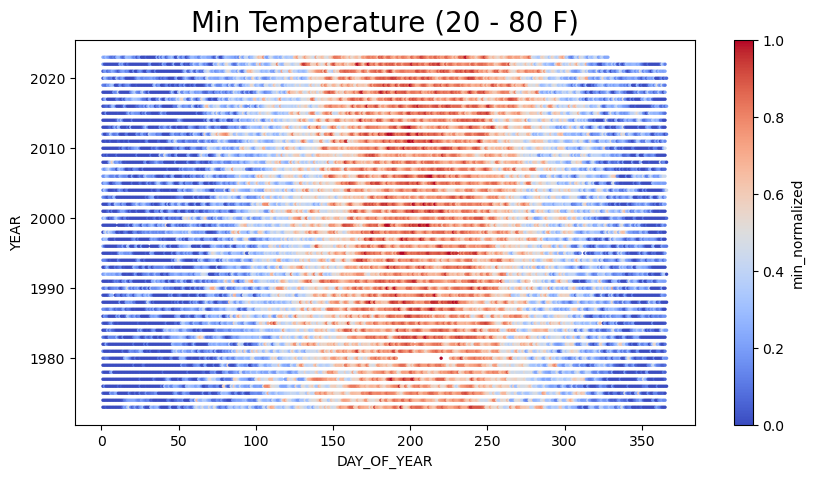

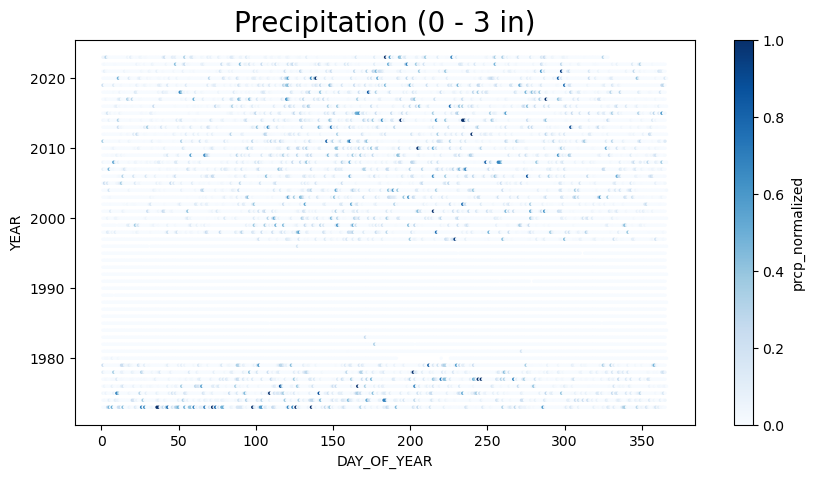

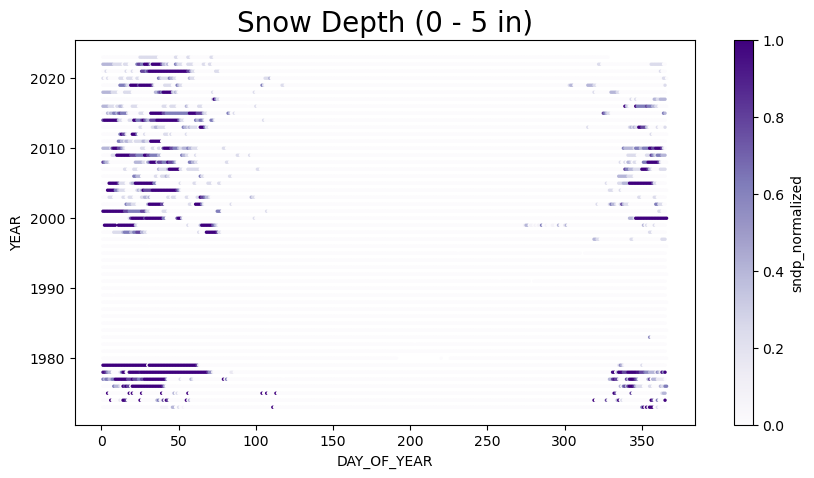

In [50]:
def normalize(day, value, min, max):
    normalized = (day[value] - min) / (max - min)
    if normalized < 0.0:
        normalized = 0.0
    if normalized > 1.0:
        normalized = 1.0
    return normalized
gsod['min_normalized'] = gsod.apply(lambda m: normalize(m, 'MIN', 20, 80), axis=1)
gsod['prcp_normalized'] = gsod.apply(lambda m: normalize(m, 'PRCP', 0, 3), axis=1)
gsod['sndp_normalized'] = gsod.apply(lambda m: normalize(m, 'SNDP', 0, 5), axis=1)
gsod.plot(x='DAY_OF_YEAR', y='YEAR', kind='scatter', s=2, c='min_normalized', colormap='coolwarm').set_title('Min Temperature (20 - 80 F)', fontsize=20)
gsod.plot(x='DAY_OF_YEAR', y='YEAR', kind='scatter', s=2, c='prcp_normalized', colormap='Blues').set_title('Precipitation (0 - 3 in)', fontsize=20)
gsod.plot(x='DAY_OF_YEAR', y='YEAR', kind='scatter', s=2, c='sndp_normalized', colormap='Purples').set_title('Snow Depth (0 - 5 in)', fontsize=20)